# 基于sklearn的降维和聚类算法

## ~~线性降维方法：~~
* ~~FA(Factor Analysis)~~
* ~~PCA(Principal Component Analysis)~~
* ~~LDA(Linear Discriminant Analysis)~~

## ~~非线性降维方法：~~
* ~~KernelPCA~~
* ~~LLE(Locally Linear Embedding)~~
* ~~t-SNE(t-Distributed Stochastic Neighbor Embedding)~~

<font color="#ff0000">**这篇只讲聚类**</font>
## 聚类方法：
* K-means
* DBSCAN——基于密度的空间聚类算法
* Spectral Clustering——谱聚类
* Hierarchical Clustering——层次聚类
* MeanShift——均值迁移
* Birch

## 总结
1. 只实现了K-means、Hierarchical Clustering、MeanShift、Birch
2. 其中只有K-means各个标签对齐，其他几个算法MeanShift没调参比kmeans差，DBSCAN能跑调不好，层次聚类和Birch准确率高但是最后一维标签对不上

In [1]:
import numpy as np
import seaborn as sns;sns.set()

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # 0-1化
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, MeanShift, Birch
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix  # 计算准确率和混淆矩阵

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from munkres import Munkres
%matplotlib inline

In [2]:
dx = load_digits()   #读取数字数据，介绍如下
''' 
    Each datapoint is a 8x8 image of a digit.
    
    =================   ==============
    Classes                         10
    Samples per class             ~180
    Samples total                 1797
    Dimensionality                  64
    Features             integers 0-16
    =================   ==============
'''
xx = dx.data         #数据
xx = MinMaxScaler().fit_transform(xx)
yy = dx.target       #标签


In [3]:
# 对齐聚类标签和实际标签
def predict_transfer(label, predict):
    # L1 should be the labels and L2 should be the clustering number we got
    L1 = np.array(label)
    L2 = np.array(predict)
    Label1 = np.unique(L1)
    nClass1 = len(Label1)
    Label2 = np.unique(L2)
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1,nClass2)
    G = np.zeros((nClass,nClass))
    for i in range(nClass1):
        ind_cla1 = L1 == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = L2 == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i,j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:,1]
    newL2 = np.zeros(L2.shape)
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]
    return newL2

# 混淆矩阵绘图
def draw_confusionmatix(label, predict):
    sns.heatmap(confusion_matrix(label, predict).T, square=True, annot=True, fmt='d', cbar=False,cmap = 'rainbow')
    plt.xlabel('true label')
    plt.ylabel('predicted label')

### K-means

In [4]:
# K-means
kmeans = KMeans(n_clusters = 10)
%time yyk = kmeans.fit_predict(xx)
#yyk = kmeans.predict(xx)

yyk = predict_transfer(yy, yyk)
acc = accuracy_score(yy,yyk)
print('accuracy_score:', acc)

Wall time: 199 ms
accuracy_score: 0.7952142459654981


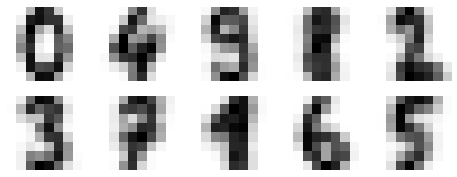

In [5]:
#可视化10类中的中心点——最具有代表性的10个数字
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)


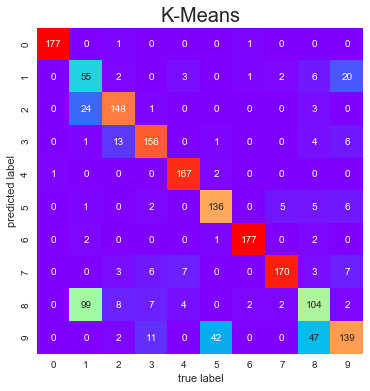

In [6]:
plt.figure(figsize=(6, 6))
draw_confusionmatix(yy, yyk)
plt.title('K-Means',fontsize=20)
plt.show()

### SpectralClustering

In [7]:
# SpectralClustering
sc = SpectralClustering(n_clusters = 10, n_init=100,assign_labels='discretize')
%time yys = sc.fit_predict(xx)
yys_t = predict_transfer(yy, yys)
acc = accuracy_score(yy,yys_t)
print('accuracy_score:', acc)

Wall time: 482 ms
accuracy_score: 0.7412353923205343


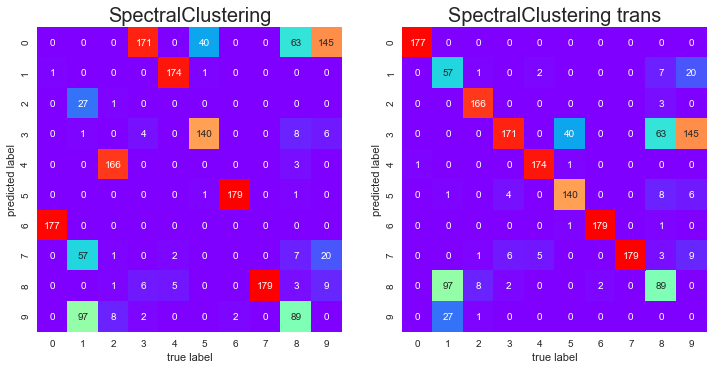

In [8]:
figure = plt.subplots(1, 2, figsize=(12,6))
plt.subplot(1,2,1)
draw_confusionmatix(yy, yys)
plt.title('SpectralClustering',fontsize=20)
plt.subplot(1,2,2)
draw_confusionmatix(yy, yys_t)
plt.title('SpectralClustering trans',fontsize=20)
plt.show()

### AgglomerativeClustering(Hierarchical Clustering)

In [9]:
# AgglomerativeClustering(Hierarchical Clustering)
hc = AgglomerativeClustering(n_clusters=10)
%time yyh = hc.fit_predict(xx)
yyh = predict_transfer(yy, yyh)
acc = accuracy_score(yy,yyh)
print('accuracy_score:', acc)

Wall time: 173 ms
accuracy_score: 0.8352810239287701


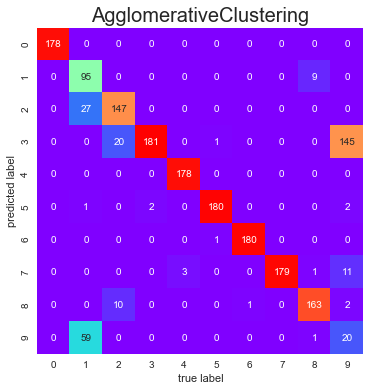

In [10]:
plt.figure(figsize=(6, 6))
draw_confusionmatix(yy, yyh)
plt.title('AgglomerativeClustering',fontsize=20)
plt.show()

### Birch
在scikit-learn中，BIRCH类实现了原理篇里讲到的基于特征树CF Tree的聚类。因此要使用BIRCH来聚类，关键是对CF Tree结构参数的处理。

在CF Tree中，几个关键的参数为内部节点的最大CF数B， 叶子节点的最大CF数L， 叶节点每个CF的最大样本半径阈值T。这三个参数定了，CF Tree的结构也基本确定了，最后的聚类效果也基本确定。可以说BIRCH的调参就是调试B,L和T。

至于类别数K，此时反而是可选的，不输入K，则BIRCH会对CF Tree里各叶子节点CF中样本的情况自己决定类别数K值，如果输入K值，则BIRCH会CF Tree里各叶子节点CF进行合并，直到类别数为K。

在scikit-learn中，BIRCH类的重要参数不多，下面一并讲解。

1. **threshold**:即叶节点每个CF的最大样本半径阈值T，它决定了每个CF里所有样本形成的超球体的半径阈值。一般来说threshold越小，则CF Tree的建立阶段的规模会越大，即BIRCH算法第一阶段所花的时间和内存会越多。但是选择多大以达到聚类效果则需要通过调参决定。默认值是0.5.如果样本的方差较大，则一般需要增大这个默认值。

2. **branching_factor**：即CF Tree内部节点的最大CF数B，以及叶子节点的最大CF数L。这里scikit-learn对这两个参数进行了统一取值。也就是说，branching_factor决定了CF Tree里所有节点的最大CF数。默认是50。如果样本量非常大，比如大于10万，则一般需要增大这个默认值。选择多大的branching_factor以达到聚类效果则需要通过和threshold一起调参决定。

3. **n_clusters**：即类别数K，在BIRCH算法是可选的，如果类别数非常多，我们也没有先验知识，则一般输入None，此时BIRCH算法第4阶段不会运行。但是如果我们有类别的先验知识，则推荐输入这个可选的类别值。默认是3，即最终聚为3类。

4. **compute_labels**：布尔值，表示是否标示类别输出，默认是True。一般使用默认值挺好，这样可以看到聚类效果。

In [11]:
# Birch
bir = Birch(n_clusters = 10)
%time yyb = bir.fit_predict(xx)
yyb_t = predict_transfer(yy, yyb)
acc = accuracy_score(yy,yyb)
print('accuracy_score:', acc)

D:\Anaconda\lib\site-packages\sklearn\cluster\birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


Wall time: 234 ms
accuracy_score: 0.19421257651641624


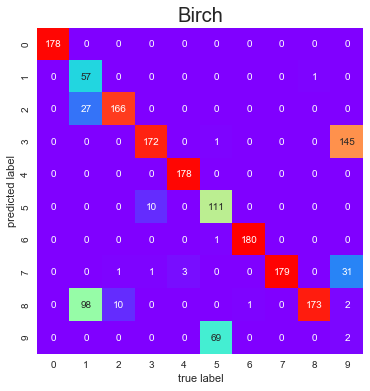

In [12]:
plt.figure(figsize=(6, 6))
draw_confusionmatix(yy, yyb_t)
plt.title('Birch',fontsize=20)
plt.show()

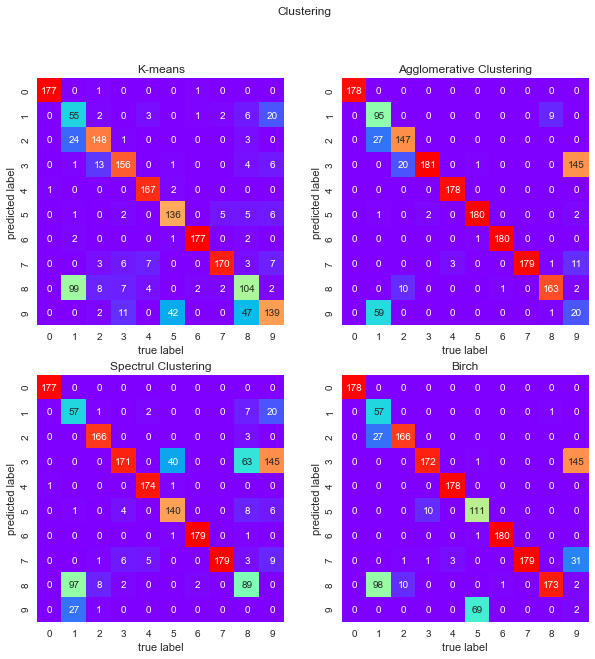

In [14]:
figure = plt.figure(figsize=(10, 10))
ax1 = figure.add_subplot(2, 2, 1, aspect = 'equal')
sns.heatmap(confusion_matrix(yy, yyk).T, square=True, annot=True, fmt='d', cbar=False,cmap = 'rainbow',
            yticklabels=dx.target_names, xticklabels=dx.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

ax2 = figure.add_subplot(2, 2, 2, aspect = 'equal')
sns.heatmap(confusion_matrix(yy, yyh).T, square=True, annot=True, fmt='d', cbar=False,cmap = 'rainbow',
            yticklabels=dx.target_names, xticklabels=dx.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

ax3 = figure.add_subplot(2, 2, 3, aspect = 'equal')
sns.heatmap(confusion_matrix(yy, yys_t).T, square=True, annot=True, fmt='d', cbar=False,cmap = 'rainbow',
            yticklabels=dx.target_names, xticklabels=dx.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

ax4 = figure.add_subplot(2, 2, 4, aspect = 'equal')
sns.heatmap(confusion_matrix(yy, yyb_t).T, square=True, annot=True, fmt='d', cbar=False,cmap = 'rainbow',
            yticklabels=dx.target_names, xticklabels=dx.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

ax1.set_title("K-means")
ax2.set_title("Agglomerative Clustering")
ax3.set_title("Spectrul Clustering")
ax4.set_title("Birch")


figure.suptitle('Clustering')
plt.show()

### DBSCAN

根据密度聚类，不需指定聚类中心数

In [ ]:
# DBSCAN
%time yyd = DBSCAN(eps = 1.2, min_samples=2).fit_predict(xx)

yyd = predict_transfer(yy,yyd)
acc = accuracy_score(yy,yyd)
print('accuracy_score:', acc)

In [ ]:
plt.figure(figsize=(6, 6))
draw_confusionmatix(yy, yyd)
plt.title('DBSCAN',fontsize=20)
plt.show()

### MeanShift
meanshift不用指定聚类中心数。

meanshift聚类步骤如下：
1. 随机生成center，把距离center bandwith内的点归为该簇，这些点归为该簇的计数加1
2. 计算center到bandwith范围内所有点的距离向量求和，得到向量shift，然后center移动shift，新的点归为该簇的计数加1
3. 重复上述步骤直至shift很小
4. 产生下一个center，重复以上步骤，根据每个点归为不同簇的次数划分类别

In [ ]:
# MeanShift
ms = MeanShift(bandwidth = 1.1)
%time yym = ms.fit_predict(xx)
yym = predict_transfer(yy, yym)
acc = accuracy_score(yy,yym)
print('accuracy_score:', acc)

In [ ]:
draw_confusionmatix(yy, yym)
plt.title('MeanShift')
plt.show()